# ASTR 596: FDS Homework 5: Hunting for Exoplanets (Due April 1 at Noon)


### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg" width="500">


### But is there a system like our own Solar system with 8 planets (sorry Pluto)? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with the techniques in class. 


### To get and analyze the Kepler data, you'll need the `lightkurve` package

> `python -m pip install lightkurve --upgrade`

### I've included some code to get the light curve, clean it and remove the NaNs, and some outliers (you can judge the wisdom of strong outlier removal when you are hunting for planets), and bin the light curve a little bit in time.


<hr>

#### Hints:


* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html), in particular [this one](https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html)

* once you get to a periodogram with `lightkurve`, `find_peaks` in `scipy` can help identify the exoplanet peaks

* You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next. This isn't strictly necessary if you do the previous steps well, but can be helpful. The tutorials page has a demo.

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
#%matplotlib notebook
#%pylab
import numpy as np
import astropy.table as at
import astropy.units as u
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.signal import find_peaks, find_peaks_cwt

In [2]:
### RUN THIS
lcfs = lk.search_lightcurve('Kepler-90', mission='Kepler').download_all()


<AxesSubplot: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

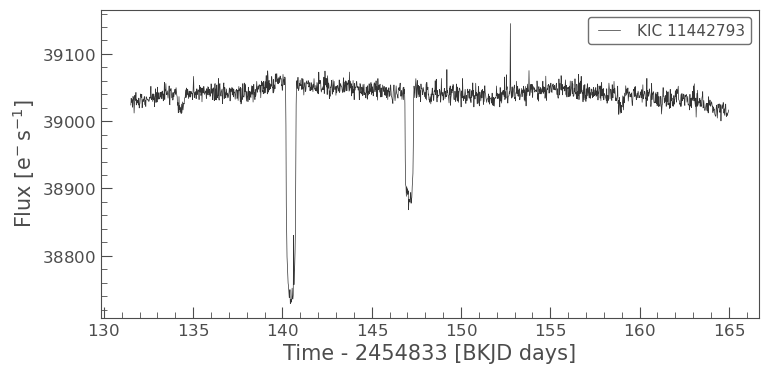

In [3]:
lcfs[0].plot()
#plt.plot(lcfs[0].time[::10].value,lcfs[0].flux[::10].value)

In [4]:
### RUN THIS
def squelch_rednoise(lc):
    corrected_lc = lc.remove_outliers(sigma_upper=10, sigma_lower=10).normalize().flatten(window_length=101)
    return corrected_lc

In [5]:
### RUN THIS - it will take a while.
stitched_lc = lcfs.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans().bin(time_bin_size=15*u.min)
clc.scatter();

In [16]:
clc.to_fits('clc.fits', overwrite=True)

# This is the data we'll deal with

# Q1. First, calculate the periodogram using lightkurve. Use the `bls` method. Look for planets between 50 and 500 day periods with a grid spacing of 0.01d - this is coarse. Use `scipy.signal.find_peaks` to identify peaks in the periodogram. Remember to exclude any peaks arising from the Earth's revolution. Plot the periodogram and highlight the peak locations. (25 pts)


In [55]:
# YOUR CODE HERE
from lightkurve.periodogram import BoxLeastSquaresPeriodogram as bls
from scipy.signal import find_peaks

bls = bls.from_lightcurve(clc,period=np.arange(50,500,0.01))

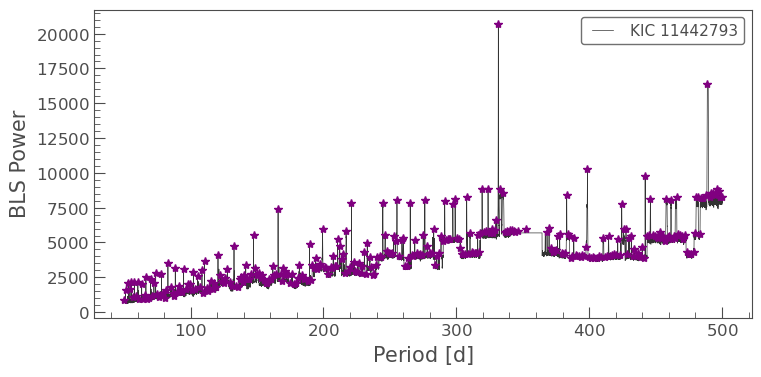

In [292]:
## All peaks

peaks = find_peaks(bls.power,distance=100) 
year_mask = (np.array(1/bls.frequency)[peaks[0]]<364.) | (np.array(1/bls.frequency)[peaks[0]]>367.) ## Remove peak at 1 year
bls_rev = bls[peaks[0]][year_mask]
    
ax = bls.plot()

ax.plot(1/bls_rev.frequency,bls_rev.power,'*',color='purple')    
plt.show()

# Q2. a. The periodogram function from lightkurve can also get a transit time and peak power using `periodogram.transit_time` and `periodogram.power` - you'll want both. Get a sorted list of candidate periods, and print it sorted by peak power. (10 pts)

In [293]:
# YOUR CODE HERE

import pandas as pd

bls_periods = pd.DataFrame({'period':1/bls_rev.frequency, 'peak_power':bls_rev.power, 't_transit':bls_rev.transit_time[peaks[0]][year_mask]})

bls_sort = bls_periods.sort_values(by='peak_power')
print(bls_sort.period)

0       50.02
14      67.45
11      64.16
9       61.31
25      80.48
        ...  
324    496.33
283    442.10
251    398.68
319    488.97
215    331.59
Name: period, Length: 328, dtype: float64


In [484]:
peak_power = np.max(1/bls_rev.frequency)
t_transit = bls_rev.transit_time[peaks[0]][year_mask][1/bls_rev.frequency==peak_power]

# Q2. b. Next sort the list of periods from longest to shorted. Check if each period has a period in your list that is either 1/2 or 1/3 the same value. If it is, exclude it. If not keep it. Select the four periods with the highest power between 0 to 100d, 100d and 200d, 200d and 300d and 300d and 400d. (15 pts)

In [447]:
# YOUR CODE HERE

## I sorted low to high and checked for things that were 2 or 3 x the smaller number 

period_sort = bls_sort.sort_values(by='period')

## Check if 1/2 or 1/3 

mask_2 = np.full(len(period_sort),True)
mask_3 = np.full(len(period_sort),True)

for i in range(len(period_sort)):
    for j in range(len(period_sort)):
        if np.isclose(period_sort.period[i]*2,period_sort.period[j],atol=0.05):
            mask_2[j] = False
        else:
            continue
            
for k in range(len(period_sort)):
    for l in range(len(period_sort)):
        if np.isclose(period_sort.period[k]*3,period_sort.period[l],atol=0.05):
            mask_3[l] = False
        else:
            continue
            
#mask = np.logical_and(mask_2,mask_3)

period_sort_masked = period_sort[mask_2&mask_3]

## Select periods with highest power between:

## 0-100d

power_0_100 = np.max(period_sort_masked.peak_power[period_sort_masked.period<100])
p_0_100 = float(period_sort_masked.period[period_sort_masked.peak_power == power_0_100])
print('0-100d: ',p_0_100,' days')

## 100-200d

power_100_200 = np.max(period_sort_masked.peak_power[(period_sort_masked.period>=100)&(period_sort_masked.period<200)])
p_100_200 = float(period_sort_masked.period[period_sort_masked.peak_power == power_100_200])
print('100-200d: ',p_100_200,' days')

## 200-300d

power_200_300 = np.max(period_sort_masked.peak_power[(period_sort_masked.period>=200)&(period_sort_masked.period<300)])
p_200_300 = float(period_sort_masked.period[period_sort_masked.peak_power == power_200_300])
print('100-200d: ',p_200_300,' days')

## 300-400d

power_300_400 = np.max(period_sort_masked.peak_power[(period_sort_masked.period>=300)&(period_sort_masked.period<400)])
p_300_400 = float(period_sort_masked.period[period_sort_masked.peak_power == power_300_400])
print('100-200d: ',p_300_400,' days')

0-100d:  82.89999999999345  days
100-200d:  194.1699999999713  days
100-200d:  299.01999999995047  days
100-200d:  319.3599999999464  days


# Q3. Select each peak period from the coarse grid in Q2.b. and then use lightkurve algorithm to refine the period within +/- 5 days, and get the best period. (25 pts)

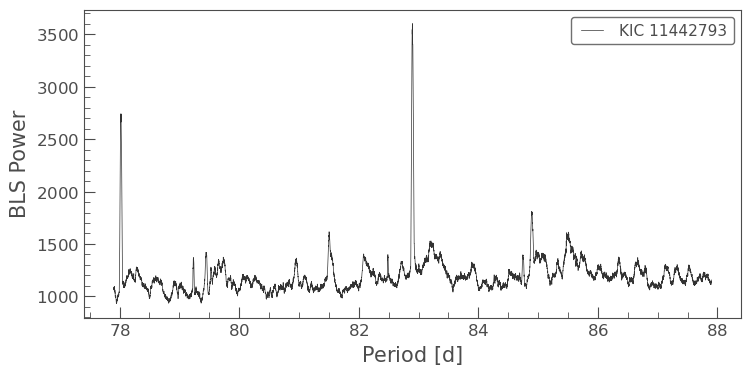

Best period:  [82.897] d


In [452]:
# YOUR CODE HERE

bls_0_100 = bls.from_lightcurve(clc,period=np.arange(p_0_100-5,p_0_100+5,0.001))
bls_0_100.plot()
plt.show()

## Best period

df_0_100 = pd.DataFrame({'period':1/bls_0_100.frequency, 'peak_power':bls_0_100.power, 't_transit':bls_0_100.transit_time})
p_0_100_ref = bls_0_100.period[bls_0_100.power == np.max(bls_0_100.power)]
print('Best period: ',p_0_100_ref)

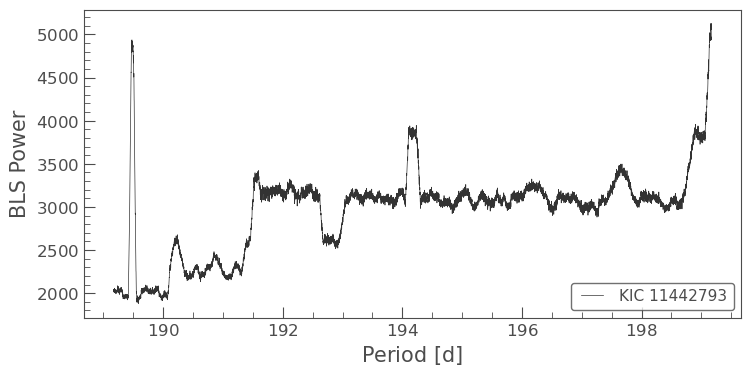

Best period:  [199.164] d


In [453]:
## 100-200 d

bls_100_200 = bls.from_lightcurve(clc,period=np.arange(p_100_200-5,p_100_200+5,0.001))
bls_100_200.plot()
plt.show()

## Best period

df_100_200 = pd.DataFrame({'period':1/bls_100_200.frequency, 'peak_power':bls_100_200.power, 't_transit':bls_100_200.transit_time})
p_100_200_ref = bls_100_200.period[bls_100_200.power == np.max(bls_100_200.power)]
print('Best period: ',p_100_200_ref)

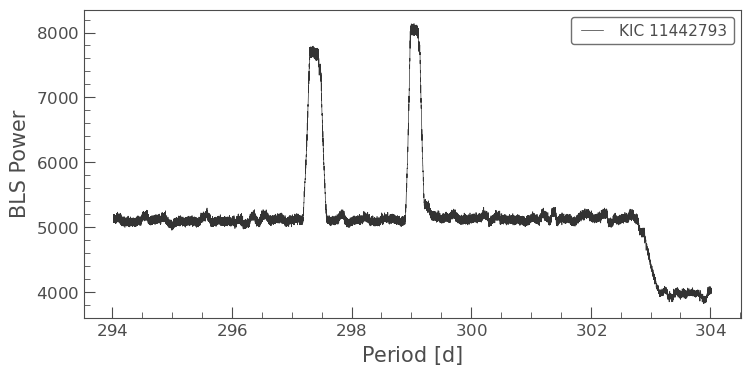

Best period:  [299.044] d


In [454]:
# 200-300 d

bls_200_300 = bls.from_lightcurve(clc,period=np.arange(p_200_300-5,p_200_300+5,0.001))
bls_200_300.plot()
plt.show()

## Best period

df_200_300 = pd.DataFrame({'period':1/bls_200_300.frequency, 'peak_power':bls_200_300.power, 't_transit':bls_200_300.transit_time})
p_200_300_ref = bls_200_300.period[bls_200_300.power == np.max(bls_200_300.power)]
print('Best period: ',p_200_300_ref)

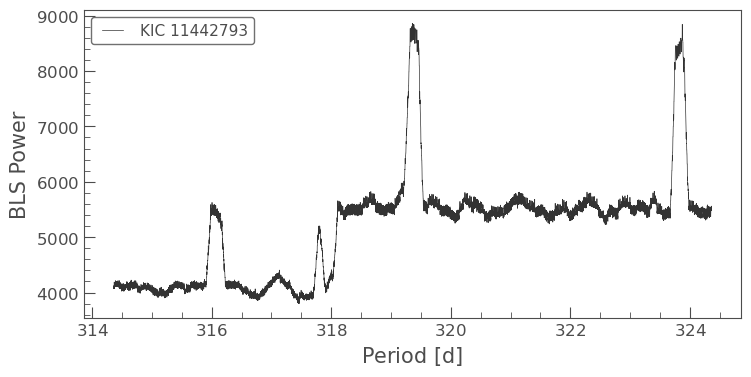

Best period:  [319.355] d


In [455]:
## 300-400 d

bls_300_400 = bls.from_lightcurve(clc,period=np.arange(p_300_400-5,p_300_400+5,0.001))
bls_300_400.plot()
plt.show()

## Best period

df_300_400 = pd.DataFrame({'period':1/bls_300_400.frequency, 'peak_power':bls_300_400.power, 't_transit':bls_300_400.transit_time})
p_300_400_ref = bls_300_400.period[bls_300_400.power == np.max(bls_300_400.power)]
print('Best period: ',p_300_400_ref)

# Q4. Use lightkurve.fold to plot the folded light curve for each of the best periods in Q3. (25 pts)

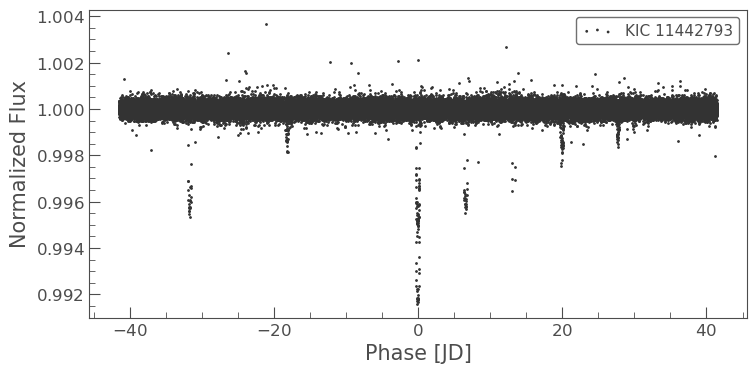

In [496]:
# YOUR CODE HERE

folded = clc.fold(period=p_0_100,epoch_time=t_transit)
folded.scatter()
plt.show()

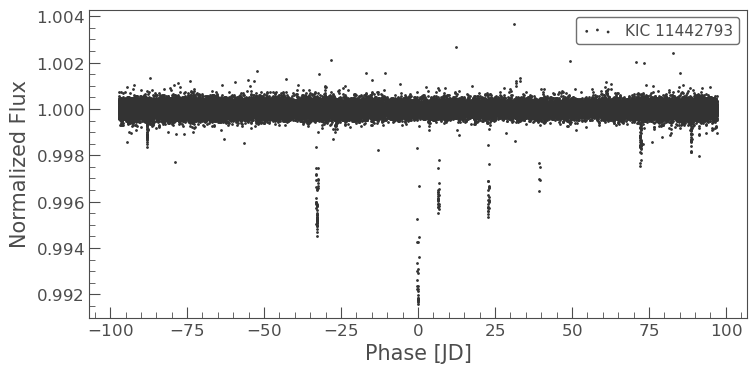

In [497]:
folded = clc.fold(period=p_100_200,epoch_time=t_transit)
folded.scatter()
plt.show()

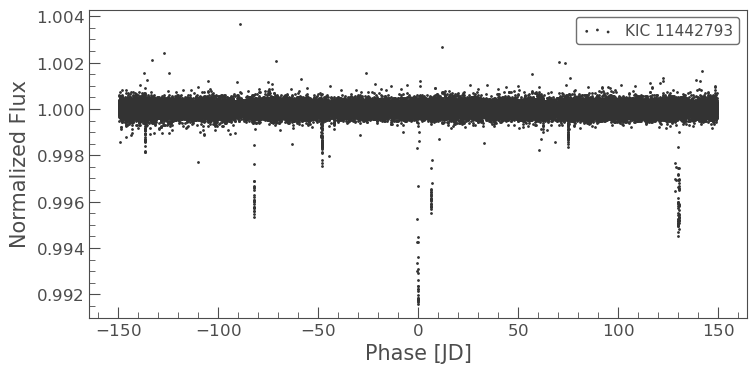

In [498]:
folded = clc.fold(period=p_200_300,epoch_time=t_transit)
folded.scatter()
plt.show()

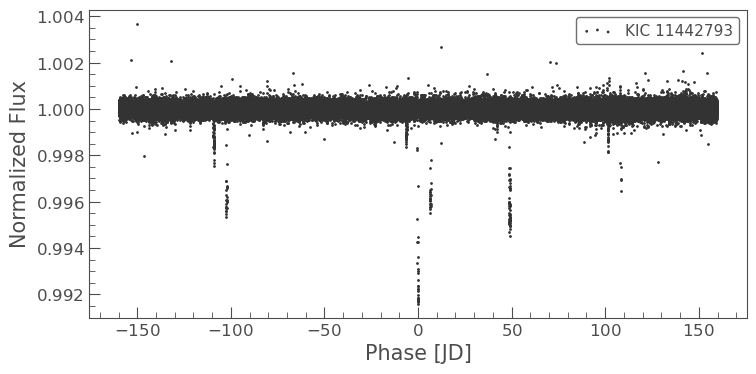

In [499]:
folded = clc.fold(period=p_300_400,epoch_time=t_transit)
folded.scatter()
plt.show()